In [1]:
# 필요 라이브러리 임포트

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [2]:
# GPU 사용환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 가져오기

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         shuffle_files = True, 
                                         with_info = True)

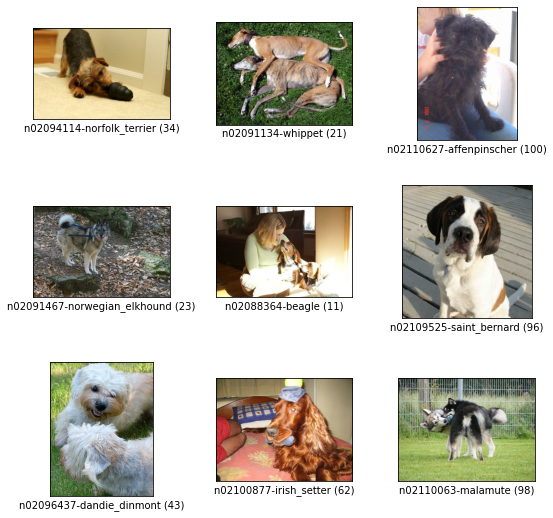

In [4]:
# 데이터 샘플 살펴보기

fig = tfds.show_examples(ds_train, ds_info)

In [5]:
# augmentation 적용을 위한 전처리 함수

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# random_augmentation 중 random_flip_left_right() 와 random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    return image,label

In [7]:
# 위에서 구현한 함수를 통해 배치 단위의 CutMix 함수 구현

def cutmix(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

In [8]:
# 배치단위의 MixUp 함수 구현

def mixup(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [9]:
# onehot 인코딩

def onehot(image, label, num_classes = 120) : 
    label = tf.one_hot(label, num_classes)
    
    return image, label

In [10]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup : 
        ds = ds.map(mixup, num_parallel_calls = 2)
        Q
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [11]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

In [12]:
# CutMix 라벨 섞기

# 섞인 이미지에 대해 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수 구현

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

NameError: name 'label_a' is not defined

In [ ]:
# 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 구현

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width // 2)
    ya = tf.math.maximum(0, y-height // 2)
    xb = tf.math.minimum(image_size_x, x+width // 2)
    yb = tf.math.minimum(image_size_y, y+width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

In [ ]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_aug_cm = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_aug_mu = apply_normalize_on_dataset(ds_train, with_mixup = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [ ]:
# CutMix 이미지 섞기

# 데이터 셋에서 2개의 이미지 가져오기

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [ ]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis = 1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [ ]:
# MixUp Augmentation

# function for mixup

def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a) * image_a + a * image_b
    mixed_label = (1-a) * label_a + a * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
# Augmentation 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [ ]:
# Augmentation + cutmix 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_cm_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [ ]:
# Augmentation + mixup 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_mu_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [ ]:
# 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_cm_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_mu_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_cm = aug_cm_resnet50.fit(
    ds_train_aug, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_mu = aug_mu_resnet50.fit(
    ds_train_aug, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

In [ ]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()